# PLOT FOR THR, LATENCY FOR POWER MODE TESTs

#### Globals

In [57]:
NETWORK="resnet50"
PLATFORM="Orin Nano"
POWER_MODES={'PM0': {},'PM1': {}}
PATH_TO_MD="../outputs/reults_power_mode_test/orin_nano/jetson_orin_nano_resume.md"

### FUNCTIONS

In [58]:
import re
import matplotlib.pyplot as plt

# Función para leer los datos del archivo .md
def read_data_from_md_for_thr(file_path):
    data = {}
    current_pm = None
    current_bs = None
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            # Detectar el Power Mode
            if line.startswith(f'# {PLATFORM} PM'):
                current_pm = line.strip().split()[-1]
            
            # Detectar el batch size
            bs_match = re.match(rf'## {NETWORK} bs (\d+)', line)
            if bs_match:
                current_bs = int(bs_match.group(1))
            
            # Leer los datos de la tabla
            table_match = re.match(r'\| (\w+) +\| +([\d.,]+)', line)
            if table_match and current_pm and current_bs is not None:
                model = table_match.group(1)
                infs_str = table_match.group(2)
                
                # Eliminar separadores de miles y convertir a flotante
                infs = float(infs_str.replace('.', '').replace(',', '.'))
                
                # Organizar los datos en el diccionario
                if model not in data:
                    data[model] = POWER_MODES
                data[model][current_pm][current_bs] = infs
    
    return data

In [59]:
# Función para graficar los datos de thr
def plot_model_data(model_name, model_data):
    plt.rcParams.update({'font.size': 14})  # Puedes ajustar el tamaño aquí
    plt.figure(figsize=(5, 3.5)).tight_layout()
    for i,(pm, data) in enumerate(model_data.items()):
        batch_sizes = list(data.keys())
        infs = list(data.values())
        plt.plot(batch_sizes, infs, marker='o', label=f'Power Mode {pm}')
    
    plt.title(f'Jetson {PLATFORM} {model_name}')
    plt.xlabel('Batch Size')
    plt.ylabel('Throughput [inf/s]')
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
    plt.minorticks_on()
    #plt.savefig(f'{model_name}.png', format='png',bbox_inches='tight')
    plt.show()

In [60]:
# Función para leer los datos del archivo .md
def read_data_from_md_for_latency(file_path):
    data = {}
    current_pm = None
    current_network = None
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            # Detectar el Power Mode
            if line.startswith(f'# {PLATFORM} PM'):
                current_pm = line.strip().split()[-1]
                if current_pm not in POWER_MODES:
                    POWER_MODES[current_pm] = {}  # Añadir a POWER_MODES si no está presente
            
            # Detectar el nombre de la red (por ejemplo, mobilenet, resnet50, etc.)
            network_match = re.match(r'## (\w+)', line)
            if network_match:
                current_network = network_match.group(1)
            
            # Leer los datos de la tabla
            table_match = re.match(r'\| (\w+)\s+\|\s+[\d.,]+.*?\|\s+([\d.,/ ]+)', line)
            if table_match and current_pm and current_network:
                model = table_match.group(1)
                latency_str = table_match.group(2).split('/')[0].strip()
                
                # Convertir la latencia a flotante
                try:
                    latency = float(latency_str.replace(',', '.'))
                except ValueError:
                    print(f"Error de conversión de latencia: '{latency_str}' en el modelo '{model}'")
                    continue
                
                # Organizar los datos en el diccionario
                if model not in data:
                    data[model] = {pm: {} for pm in POWER_MODES.keys()}
                data[model][current_pm][current_network] = latency
    return data

In [61]:
# Función para graficar los datos
def plot_model_latency(model_name, model_data):
    plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente
    plt.figure(figsize=(5, 3.5)).tight_layout()

    networks = list(model_data[next(iter(POWER_MODES))].keys())  # Listado de redes

    # Crear listas de latencias para cada modo de energía definido en POWER_MODES
    latencies_by_pm = {pm: [model_data[pm].get(net, 0) for net in networks] for pm in POWER_MODES.keys()}

    # Crear gráfico de barras
    bar_width = 0.35
    index = range(len(networks))

    # Desplazar las barras para cada modo de energía
    for i, (pm, latencies) in enumerate(latencies_by_pm.items()):
        plt.bar([x + i * bar_width for x in index], latencies, bar_width, label=f'Power Mode {pm}')

    plt.title(f'Latency Performance of {model_name}')
    plt.xlabel('Network')
    plt.ylabel('Latency (ms)')
    plt.xticks([i + (len(POWER_MODES) - 1) * bar_width / 2 for i in index], networks)
    plt.legend()
    plt.grid(True)
    # Guardar el gráfico como PDF con el nombre del modelo
    #plt.savefig(f'{model_name}_latency.pdf', format='pdf')
    plt.show()

#### plotea el Thr.

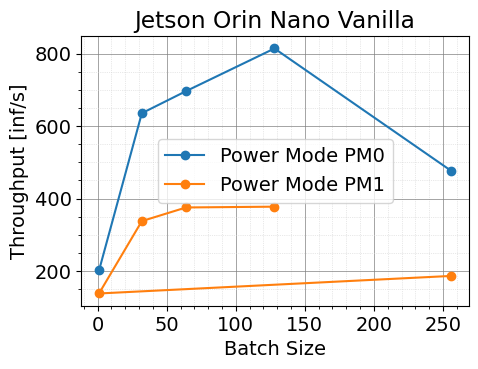

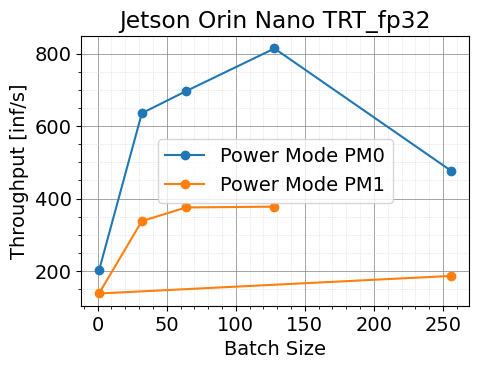

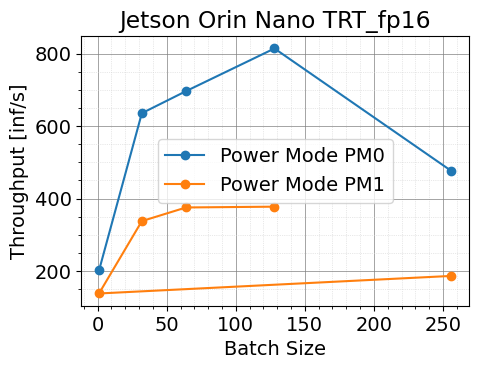

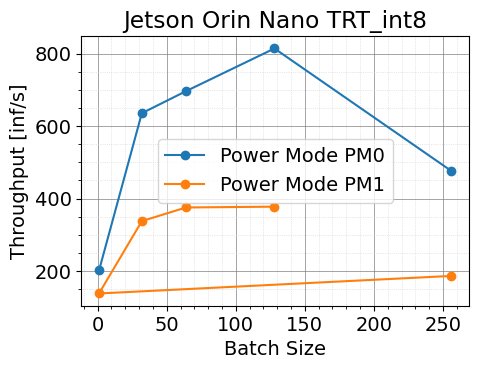

In [62]:
# Ruta del archivo .md
file_path = PATH_TO_MD

# Leer los datos del archivo .md
data = read_data_from_md_for_thr(file_path)

# Graficar cada modelo
for model_name, model_data in data.items():
    plot_model_data(model_name, model_data)


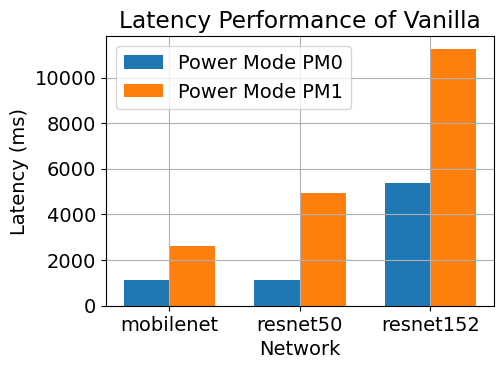

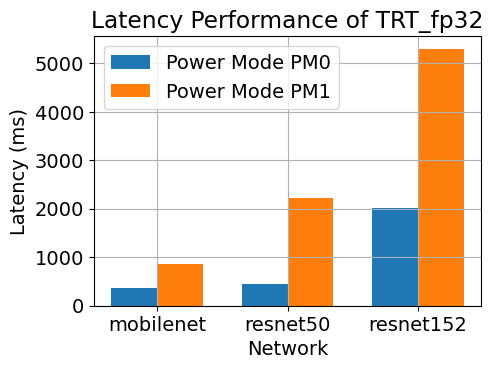

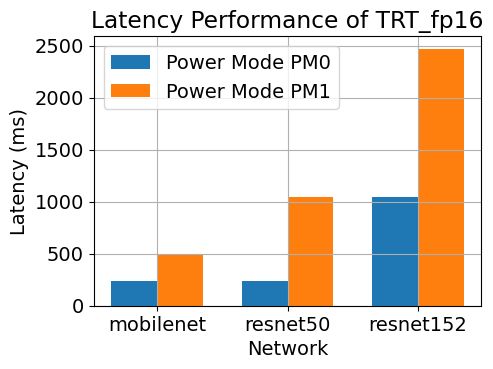

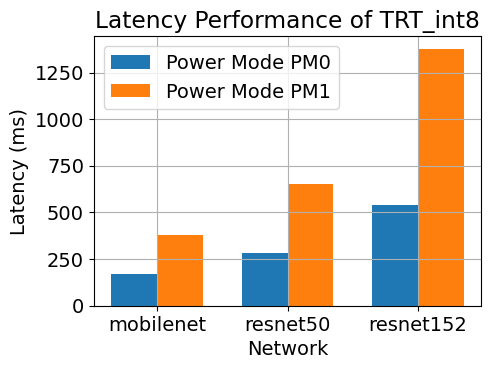

In [63]:
# Ruta del archivo .md
file_path = PATH_TO_MD

# Leer los datos del archivo .md
data = read_data_from_md_for_latency(file_path)

# Graficar cada modelo
for model_name, model_data in data.items():
    plot_model_latency(model_name, model_data)